<img src='https://certificate.tpq.io/quantsdev_banner_color.png' width="250px" align="right">

# Reinforcement Learning

&copy; Dr Yves J Hilpisch | The Python Quants GmbH

[quants@dev Discord Server](https://discord.gg/uJPtp9Awaj) | [@quants_dev](https://twitter.com/quants_dev) | <a href="mailto:qd@tpq.io">qd@tpq.io</a>

<img src="https://hilpisch.com/aiif_cover_shadow.png" width="300px" align="left">

## Simulated Financial Processes

In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
from pylab import plt
from collections import deque
plt.style.use('seaborn')
os.environ['PYTHONHASHSEED'] = '0'
np.set_printoptions(precision=4, suppress=True)

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'

In [4]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential

## Setting Seeds

In [6]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    env.seed(seed)

## Q Learning

In [7]:
class DQLAgent:
    def __init__(self, gamma=0.95, hu=24, ed=0.99, finish=False):
        self.finish = finish
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = ed
        self.gamma = gamma
        self.batch_size = 32
        self.max_treward = 0
        self.averages = list()
        self.memory = deque(maxlen=2000)
        self.osn = env.observation_space.shape[0]
        self.trewards = []
        self.model = self._build_model(hu)
        
    def _build_model(self, hu):
        model = Sequential()
        model.add(Dense(hu, input_dim=self.osn,
                        activation='relu'))
        model.add(Dense(hu, activation='relu'))
        model.add(Dense(env.action_space.n, activation='linear'))
        model.compile(loss='mse', optimizer='adam')
        return model
        
    def act(self, state):
        if random.random() <= self.epsilon:  # exploration
            return env.action_space.sample()
        action = self.model.predict(state)  # exploitation
        return np.argmax(action)
    
    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            if not done:
                reward += self.gamma * np.amax(
                    self.model.predict(next_state)[0])
            target = self.model.predict(state)
            target[0, action] = reward
            self.model.fit(state, target, epochs=1,
                           verbose=False)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def learn(self, episodes):
        for e in range(1, episodes + 1):
            state = env.reset()
            state = np.reshape(state, [1, self.osn])
            for _ in range(5000):
                action = self.act(state)
                next_state, reward, done, info = env.step(action)
                next_state = np.reshape(next_state,
                                        [1, self.osn])
                self.memory.append([state, action, reward,
                                     next_state, done])
                state = next_state
                if done:
                    treward = _ + 1
                    self.trewards.append(treward)
                    av = sum(self.trewards[-25:]) / 25
                    self.averages.append(av)
                    self.max_treward = max(self.max_treward, treward)
                    templ = 'episode: {:4d}/{} | treward: {:4d} | '
                    templ += 'av: {:5.1f} | max: {:4d}'
                    print(templ.format(e, episodes, treward, av,
                                       self.max_treward), end='\r')
                    break
            if av > 195 and self.finish:
                break
            if len(self.memory) > self.batch_size:
                self.replay()
        print()
    def test(self, episodes):
        trewards = []
        for e in range(1, episodes + 1):
            env_ = Simul(env.symbol, env.features, env.steps, x0=env.x0,
                    kappa=env.kappa, theta=env.theta, sigma=env.sigma,
                    normalize=env.normalize, mu=env.mu, std=env.std)
            state = env_.reset()
            for _ in range(10001):
                state = np.reshape(state, [1, self.osn])
                action = np.argmax(self.model.predict(state))
                next_state, reward, done, info = env_.step(action)
                state = next_state
                if done:
                    treward = _ + 1
                    trewards.append(treward)
                    print('episode: {:4d}/{} | treward: {:4d}'
                          .format(e, episodes, treward), end='\r')
                    break
        return trewards

## Simulation Environment (1)

In [8]:
class observation_space:
    def __init__(self, n):
        self.shape = (n,)

In [9]:
class action_space:
    def __init__(self, n):
        self.n = n
    def sample(self):
        return random.randint(0, self.n - 1)

In [10]:
class Simul:
    def __init__(self, symbol, features, steps,
                 x0=100, kappa=1, theta=100, sigma=0.2,
                 normalize=True, mu=None, std=None):
        self.symbol = symbol
        self.features = features
        self.steps = steps
        self.x0 = x0
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.normalize = normalize
        self.mu = mu
        self.std = std
        self.observation_space = observation_space(4)
        self.osn = self.observation_space.shape[0]
        self.action_space = action_space(2)
        self.min_accuracy = 0.525  # minimum required prediction accuracy
        self._simulate_data()
        self._prepare_data()
    def _simulate_data(self):
        s = [self.x0]
        dt = 1 / self.steps  # "one year" as the default assumption
        for t in range(1, self.steps + 1):
            s_ = (s[t - 1] + self.kappa * (self.theta - s[t - 1]) * dt + s[t - 1] *
                  self.sigma * math.sqrt(dt) * random.gauss(0, 1))
            s.append(s_)
        self.data = pd.DataFrame(s, columns=[self.symbol],
                                index=pd.date_range(start='2022-1-1',
                                                    end='2023-1-1',
                                                    periods=self.steps+1))
    def _prepare_data(self):
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data.dropna(inplace=True)
        if self.normalize:
            if self.mu is None or self.std is None:
                self.mu, self.std = self.data.mean(), self.data.std()
            self.data = (self.data - self.mu) / self.std
        self.data['d'] = np.where(self.data['r'] > 0, 1, 0)
    def _get_state(self):
        return self.data[self.features].iloc[
            self.bar - self.osn:self.bar].values
    def seed(self, seed=None):
        pass
    def reset(self):
        self.treward = 0
        self.accuracy = 0
        self.bar = self.osn
        state = self._get_state()
        return state
    def step(self, action):
        correct = action == self.data['d'].iloc[self.bar]
        reward = 1 if correct else 0
        self.treward += reward
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.osn)
        if self.bar >= len(self.data - 2):
            done = True
        elif reward == 1:
            done = False
        elif (self.accuracy < self.min_accuracy and
              self.bar > self.osn + 5):
            done = True
        else:
            done = False
        state = self._get_state()
        info = {}
        return state, reward, done, info

## Simulation Scenarios

In [11]:
sym = 'EUR='

In [103]:
scenario = 4

In [104]:
if scenario == 1:
    # baseline scenario (price feature)
    env = Simul(sym, sym, steps=365,
                x0=1, kappa=1, theta=1.1, sigma=0.0,
                normalize=False)
elif scenario == 2:
    # trend scenario (price feature)
    env = Simul(sym, sym, steps=365,
                x0=100, kappa=1, theta=500, sigma=0.25,
                normalize=False)
elif scenario == 3:
    # mean reversion scenario (price feature)
    env = Simul(sym, sym, steps=365,  # feature = price data
                x0=100, kappa=7.5, theta=100, sigma=0.1,
                normalize=False)
elif scenario == 4:
    # mean reversion scenario (return feature)
    env = Simul(sym, 'r', steps=365,  # feature = returns data
                x0=100, kappa=7.5, theta=100, sigma=0.1,
                normalize=True)
else:
    raise ValueError('No valid scenario value provided.')

In [105]:
env.data.head()

,EUR=,r,d
2022-01-02,0.024477,0.374929,1
2022-01-03,0.124929,0.466582,1
2022-01-04,-0.039497,-0.784880,0
2022-01-05,0.263462,1.421503,1
2022-01-06,0.190164,-0.352561,0


In [106]:
env.data[sym].diff().apply(np.sign).value_counts()

 1.0    192
-1.0    172
Name: EUR=, dtype: int64

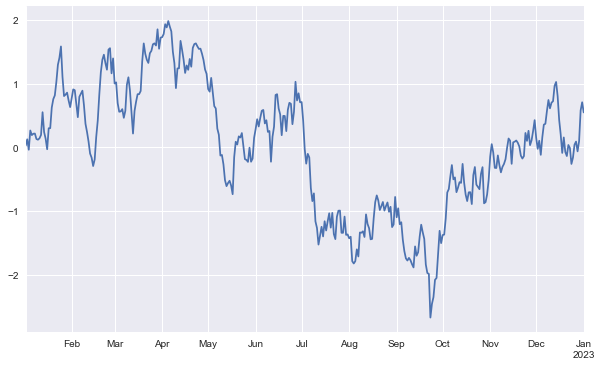

In [107]:
env.data[sym].plot(figsize=(10, 6));

In [108]:
env.reset()

array([ 0.3749,  0.4666, -0.7849,  1.4215])

In [109]:
a = env.action_space.sample()
a

1

In [110]:
env.step(a)

(array([ 0.4666, -0.7849,  1.4215, -0.3526]), 0, False, {})

## Training the Agent

In [111]:
set_seeds(100)
agent = DQLAgent(gamma=0.5, hu=24, ed=0.99)

In [112]:
episodes = 250

In [118]:
%time agent.learn(episodes)

episode:  250/250 | treward:  361 | av: 234.4 | max:  361
CPU times: user 34.7 s, sys: 3.48 s, total: 38.1 s
Wall time: 33.1 s


In [119]:
agent.epsilon

0.009920974201040588

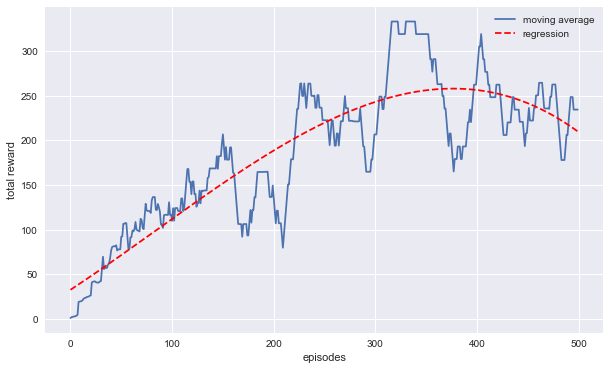

In [120]:
plt.figure(figsize=(10, 6))
x = range(len(agent.averages))
y = np.polyval(np.polyfit(x, agent.averages, deg=3), x)
plt.plot(agent.averages, label='moving average')
plt.plot(x, y, 'r--', label='regression')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.legend();

## Testing the Agent

In [121]:
trewards = agent.test(15)

In [122]:
trewards

[7, 6, 8, 94, 7, 6, 14, 8, 8, 6, 6, 16, 10, 16, 6]

In [123]:
sum(trewards) / len(trewards)

14.533333333333333

## Base Simulation and Second One

In [124]:
env_ = Simul(env.symbol, env.features, env.steps, x0=env.x0,
                    kappa=env.kappa, theta=env.theta, sigma=env.sigma,
                    normalize=env.normalize, mu=env.mu, std=env.std)

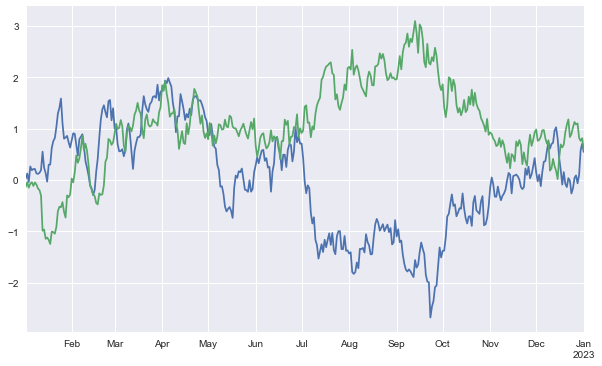

In [125]:
ax = env.data[sym].plot(figsize=(10, 6))
env_.data[sym].plot(ax=ax);

<img src="https://certificate.tpq.io/quantsdev_banner_color.png" alt="quants@dev" width="35%" align="right" border="0"><br>

[quants@dev Discord Server](https://discord.gg/uJPtp9Awaj) | [@quants_dev](https://twitter.com/quants_dev) | <a href="mailto:qd@tpq.io">qd@tpq.io</a>